In [1]:
#Depression Detection from Text using Machine Learning and NLP


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# DL models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")


In [3]:
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score, roc_auc_score
import joblib  # For saving models
import os  # Useful for loading/saving files


In [4]:
file_path = "../dataset/Mental-Health-Twitter_RawData.csv"

# Load dataset
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB


Unnamed: 0      0
post_id         0
post_created    0
post_text       0
user_id         0
followers       0
friends         0
favourites      0
statuses        0
retweets        0
label           0
dtype: int64

In [6]:
df.head()

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [7]:
df.shape

(20000, 11)

In [8]:
#Preprocessing
from nltk.corpus import stopwords            
from nltk.tokenize import word_tokenize     
from nltk.sentiment import SentimentIntensityAnalyzer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize 

In [9]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')     
nltk.download('vader_lexicon')   

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\chimi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chimi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chimi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chimi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:


def preprocess_text(text):
    # 1. Convert text to lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove punctuation and special characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove English stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # 6. Join tokens back into a cleaned string
    cleaned_text = " ".join(filtered_tokens)

    return cleaned_text


In [11]:
# Apply the cleaning function to the 'Review' column in the dataset
df['cleaned_review'] = df['post_text'].astype(str).apply(preprocess_text)

In [12]:
print(df[['post_text', 'cleaned_review']].head(n=20))

                                            post_text  \
0   It's just over 2 years since I was diagnosed w...   
1   It's Sunday, I need a break, so I'm planning t...   
2   Awake but tired. I need to sleep but my brain ...   
3   RT @SewHQ: #Retro bears make perfect gifts and...   
4   It’s hard to say whether packing lists are mak...   
5   Making packing lists is my new hobby... #movin...   
6   At what point does keeping stuff for nostalgic...   
7   Currently in the finding-boxes-of-random-shit ...   
8   Can't be bothered to cook, take away on the wa...   
9   RT @itventsnews: ITV releases promo video for ...   
10  ... also, I have too much stuff. Way, way too ...   
11  I never want to put one of these together agai...   
12  Moving stuff is bloomin’ knackering... and the...   
13  Back at the house, moving stuff. It’s so peace...   
14  Urgh. Anxiety. FFS where does it come from?! (...   
15  I have too much stuff. Way, way too much... Ma...   
16  Hideous traffic on the A14.

In [13]:
# Drop the specified columns
df = df.drop(columns=['Unnamed: 0', 'post_id', 'post_created', 'user_id'])

# Check the remaining columns
print(df.columns)

Index(['post_text', 'followers', 'friends', 'favourites', 'statuses',
       'retweets', 'label', 'cleaned_review'],
      dtype='object')


In [14]:
# Count the number of null values per column
print(df.isnull().sum())

post_text         0
followers         0
friends           0
favourites        0
statuses          0
retweets          0
label             0
cleaned_review    0
dtype: int64


In [15]:
# Display rows that contain at least one null value
print(df[df.isnull().any(axis=1)])

Empty DataFrame
Columns: [post_text, followers, friends, favourites, statuses, retweets, label, cleaned_review]
Index: []


In [16]:
# Quick summary of the dataframe including counts, data types, and null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   post_text       20000 non-null  object
 1   followers       20000 non-null  int64 
 2   friends         20000 non-null  int64 
 3   favourites      20000 non-null  int64 
 4   statuses        20000 non-null  int64 
 5   retweets        20000 non-null  int64 
 6   label           20000 non-null  int64 
 7   cleaned_review  20000 non-null  object
dtypes: int64(6), object(2)
memory usage: 1.2+ MB
None


In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer

def classify_depression_vader(df):
    # Initialize VADER from NLTK
    sia = SentimentIntensityAnalyzer()
    
    # Define rule-based depression level
    def depression_level(score):
        if score > 0.2:
            return 'Not Depressed'
        elif -0.4 <= score <= 0.2:
            return 'Moderately Depressed'
        else:
            return 'Highly Depressed'

    # Compute compound scores
    df['compound_score'] = df['cleaned_review'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

    # Classify based on compound score
    df['depression_level'] = df['compound_score'].apply(depression_level)

    # Print percentage distribution
    level_counts = df['depression_level'].value_counts(normalize=True) * 100
    print("Depression Level Distribution (%):")
    print(level_counts.to_string())

    return df


In [18]:
# Assuming df has a 'cleaned_review' column
df = classify_depression_vader(df)
print(df[['cleaned_review', 'compound_score', 'depression_level']].head())


Depression Level Distribution (%):
depression_level
Moderately Depressed    48.385
Not Depressed           34.400
Highly Depressed        17.215
                                      cleaned_review  compound_score  \
0  years since diagnosed anxiety depression today...         -0.6597   
1  sunday need break im planning spend little tim...          0.0000   
2                 awake tired need sleep brain ideas         -0.4404   
3  rt sewhq retro bears make perfect gifts great ...          0.9042   
4  hard say whether packing lists making life eas...          0.1779   

       depression_level  
0      Highly Depressed  
1  Moderately Depressed  
2      Highly Depressed  
3         Not Depressed  
4  Moderately Depressed  


In [19]:
# Function to tokenize text into a list of words
def tokenize_text(text):
    # Convert text to lowercase and tokenize into words
    tokens = word_tokenize(text.lower())  # lowercase for uniformity
    return tokens

# Apply tokenization
df['tokens'] = df['cleaned_review'].astype(str).apply(tokenize_text)


In [20]:
# View the first 10 rows of cleaned reviews alongside their tokenized lists
print(df[['cleaned_review', 'tokens']].head())

                                      cleaned_review  \
0  years since diagnosed anxiety depression today...   
1  sunday need break im planning spend little tim...   
2                 awake tired need sleep brain ideas   
3  rt sewhq retro bears make perfect gifts great ...   
4  hard say whether packing lists making life eas...   

                                              tokens  
0  [years, since, diagnosed, anxiety, depression,...  
1  [sunday, need, break, im, planning, spend, lit...  
2          [awake, tired, need, sleep, brain, ideas]  
3  [rt, sewhq, retro, bears, make, perfect, gifts...  
4  [hard, say, whether, packing, lists, making, l...  


In [21]:
# Tokenize text by splitting on spaces and create a 'tokens' column
df['tokens'] = df['cleaned_review'].astype(str).apply(lambda x: x.split())

# View
df[['cleaned_review', 'tokens']].head()

,cleaned_review,tokens
0,years since diagnosed anxiety depression today...,"[years, since, diagnosed, anxiety, depression,..."
1,sunday need break im planning spend little tim...,"[sunday, need, break, im, planning, spend, lit..."
2,awake tired need sleep brain ideas,"[awake, tired, need, sleep, brain, ideas]"
3,rt sewhq retro bears make perfect gifts great ...,"[rt, sewhq, retro, bears, make, perfect, gifts..."
4,hard say whether packing lists making life eas...,"[hard, say, whether, packing, lists, making, l..."


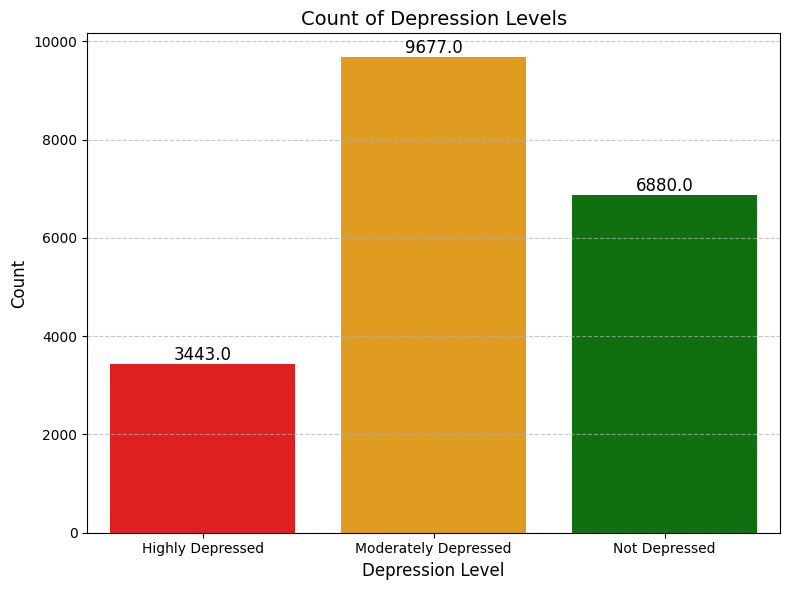

In [22]:
#Exploratory data analysis

# Define the palette with all depression levels present in the data
palette = {
    'Not Depressed': 'green',
    'Moderately Depressed': 'orange',
    'Highly Depressed': 'red'
}

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="depression_level", data=df, palette=palette)

# Add titles and labels
plt.title('Count of Depression Levels', fontsize=14)
plt.xlabel('Depression Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate counts on the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=12, color='black')

# Show the plot
plt.tight_layout()
plt.show()


In [23]:
from wordcloud import WordCloud

def plot_wordclouds_by_depression_level(df):
    # Loop through each unique depression level
    for level in df['depression_level'].dropna().unique():
        # Combine all cleaned_review text for the current level
        text = " ".join(df[df['depression_level'] == level]['cleaned_review'].dropna())

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {level} Depression Level", fontsize=16)
        plt.show()


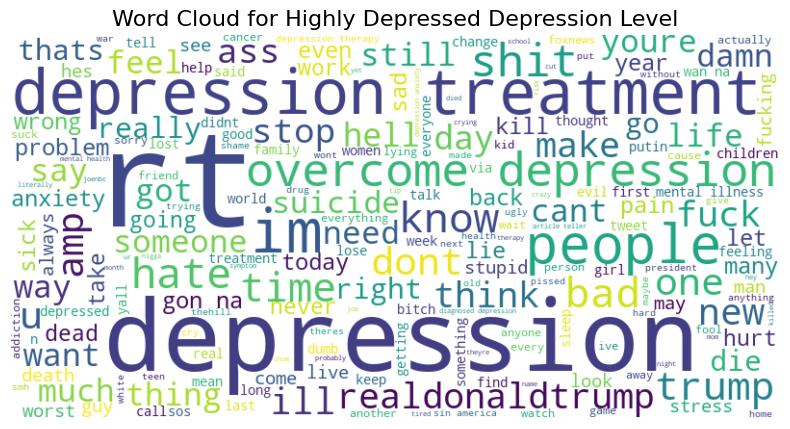

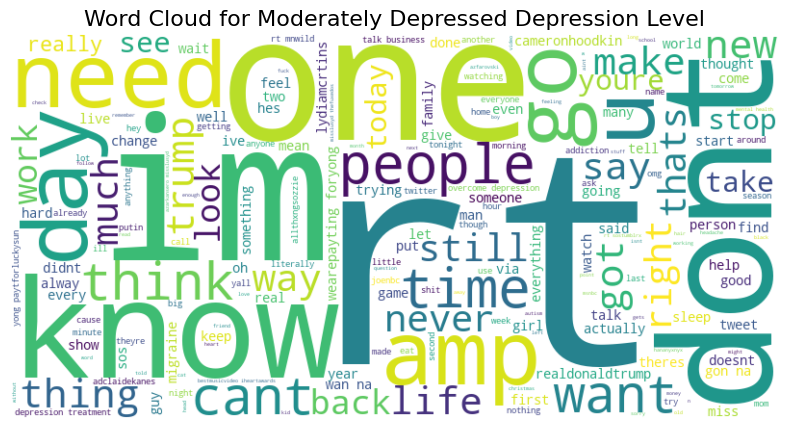

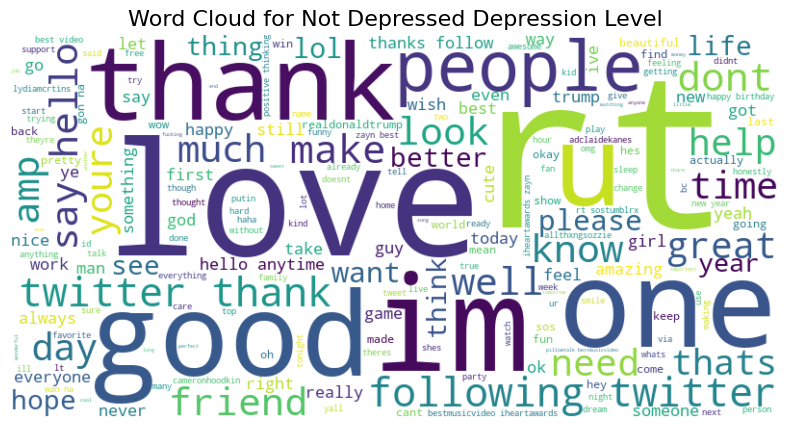

In [24]:
plot_wordclouds_by_depression_level(df)


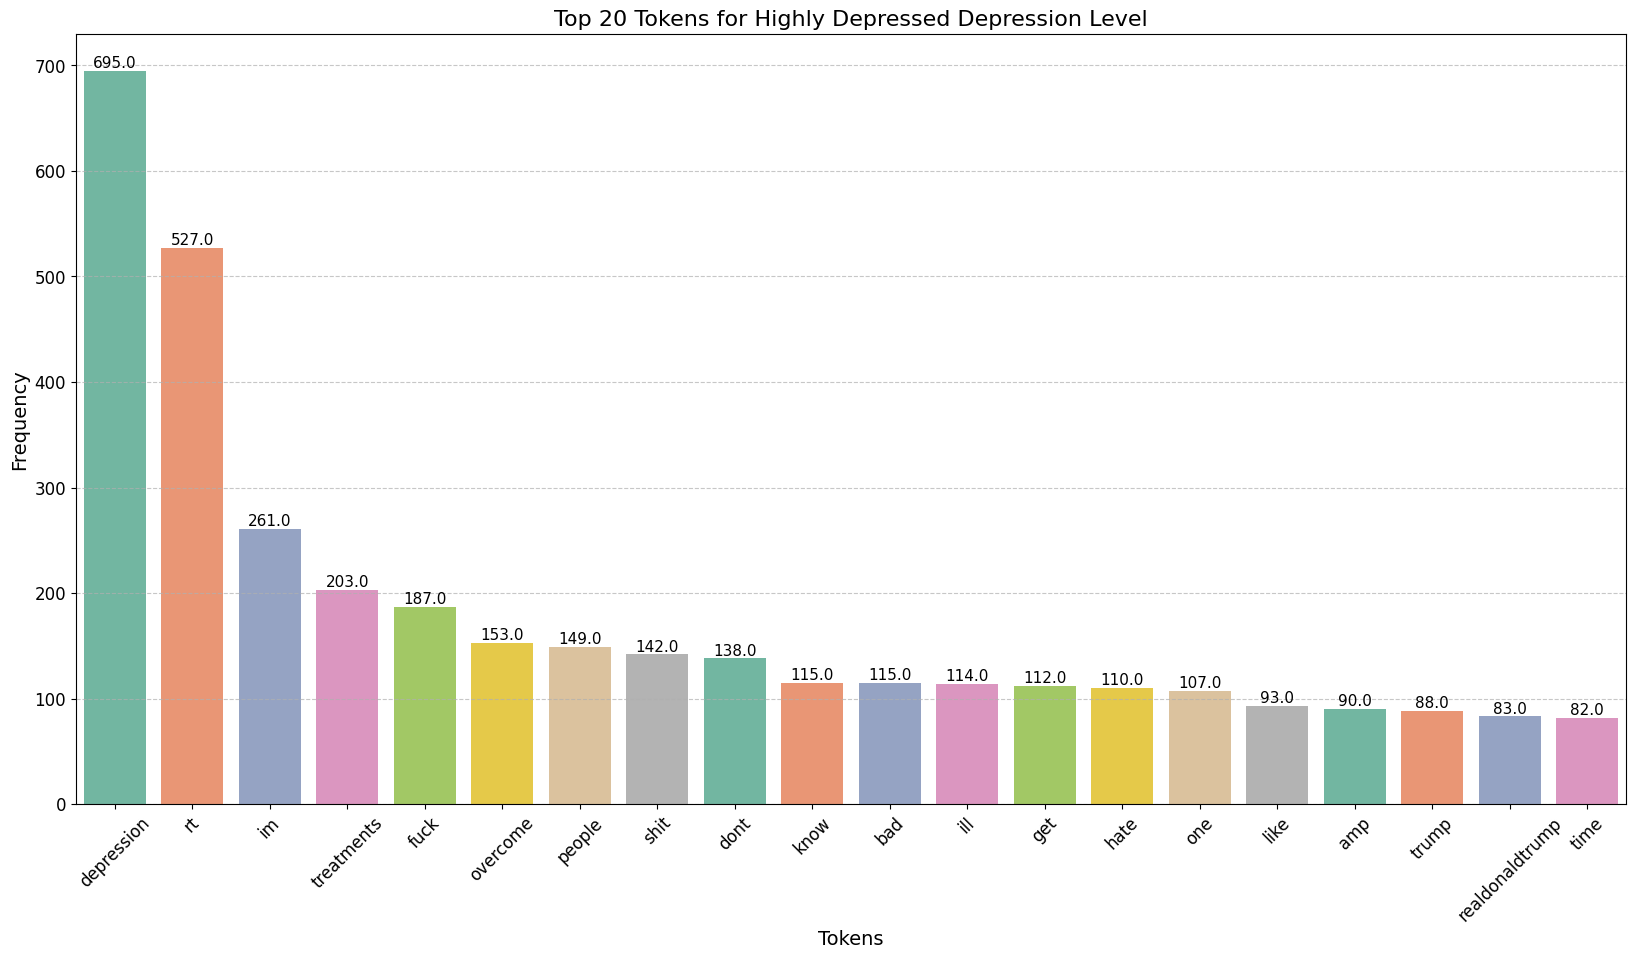

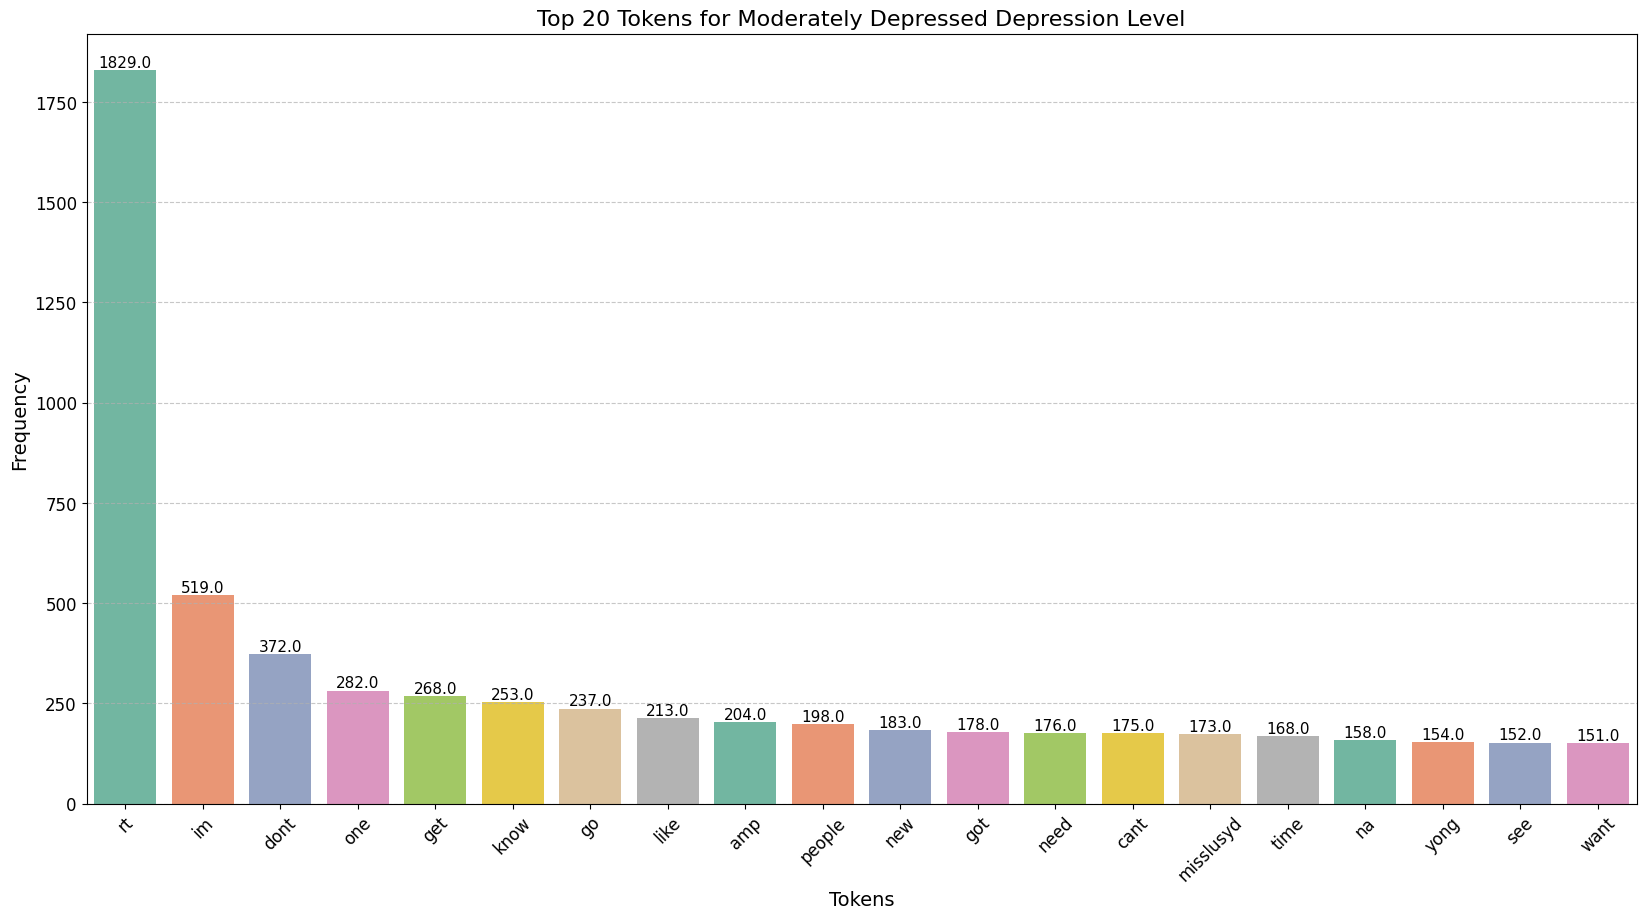

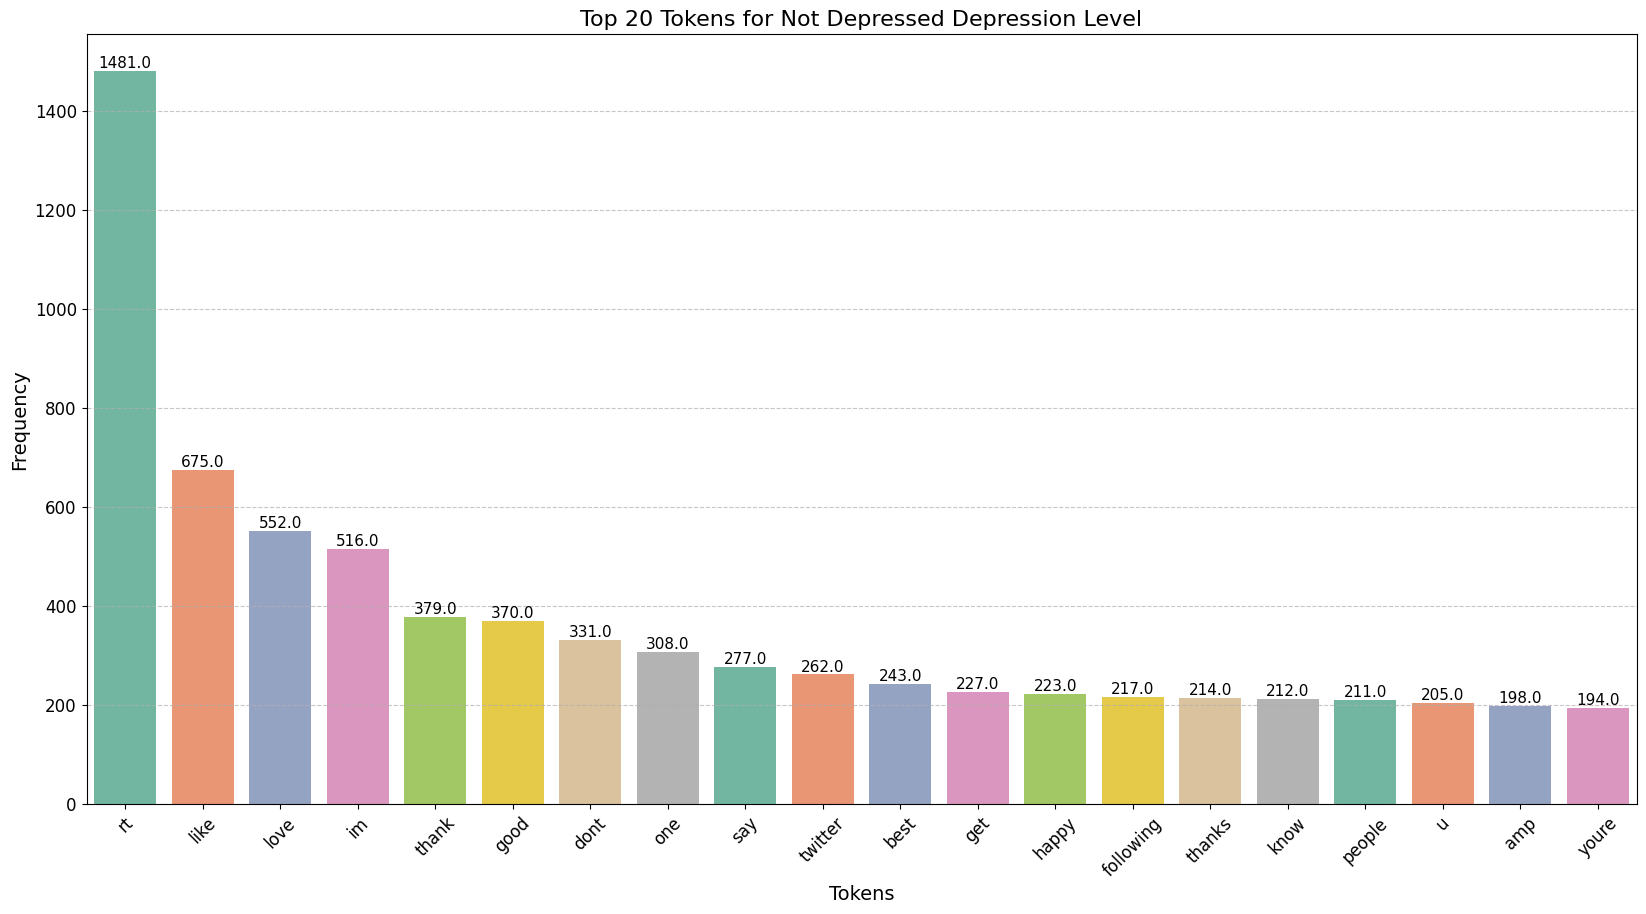

In [25]:
from collections import Counter


def plot_top_tokens_by_depression_level(df, top_n=20):
    depression_levels = df['depression_level'].dropna().unique()

    for level in depression_levels:
        # Filter tokens for current depression level
        level_tokens = df[df['depression_level'] == level]['tokens'].dropna()

        # Flatten all token lists
        all_tokens = [token for sublist in level_tokens for token in sublist]

        # Count token frequencies
        token_counts = Counter(all_tokens)
        most_common_tokens = token_counts.most_common(top_n)

        if not most_common_tokens:
            print(f"No tokens found for depression level: {level}")
            continue

        # Unzip into words and counts
        words, counts = zip(*most_common_tokens)

        # Plot bar chart
        plt.figure(figsize=(20, 10))
        sns.barplot(x=list(words), y=list(counts), palette='Set2')
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(f'Top {top_n} Tokens for {level} Depression Level', fontsize=16)
        plt.xlabel('Tokens', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add frequency labels on top of bars
        ax = plt.gca()
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=11)

        plt.show()
plot_top_tokens_by_depression_level(df)


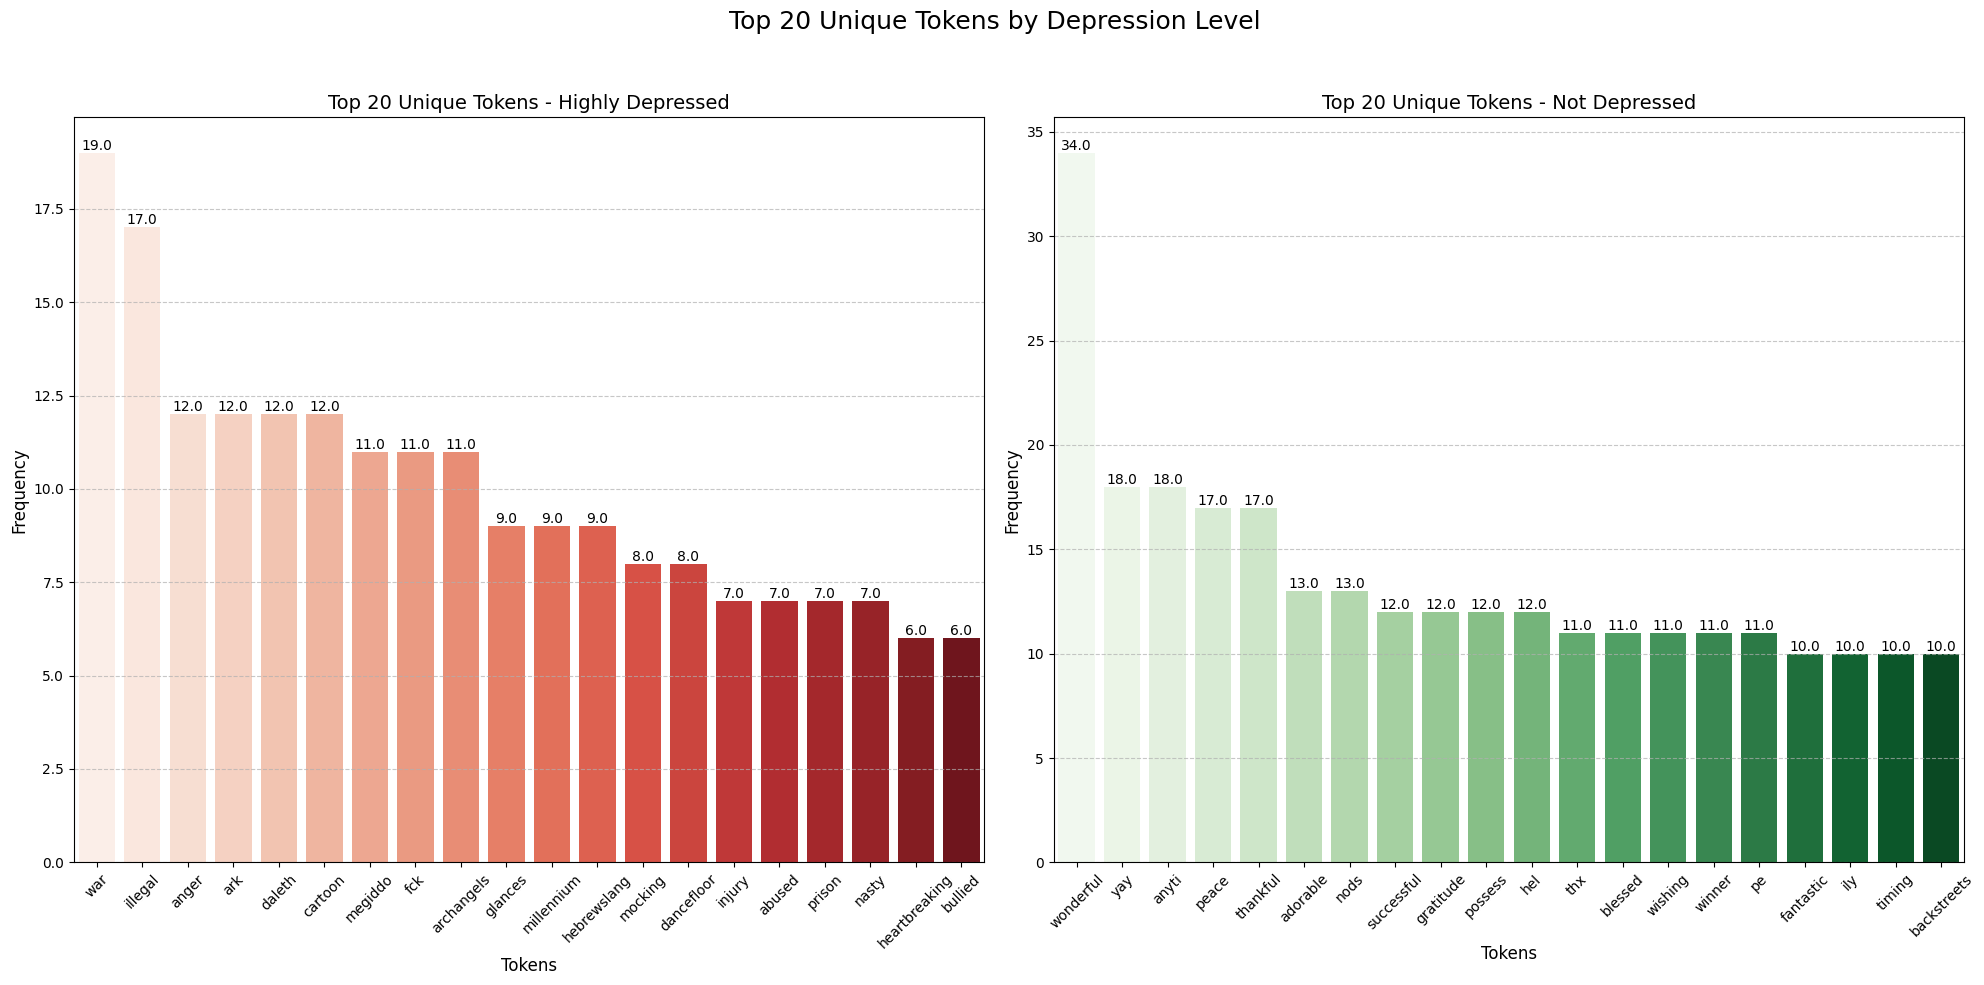

In [26]:

def plot_unique_top_tokens(df, target_level, other_levels, top_n=20, ax=None, palette='Blues'):
    # All tokens for the target depression level
    target_tokens = [token for sublist in df[df['depression_level'] == target_level]['tokens'] for token in sublist]

    # All tokens for the other depression levels
    other_tokens = set(token for sublist in df[df['depression_level'].isin(other_levels)]['tokens'] for token in sublist)

    # Keep only tokens unique to target level
    unique_tokens = [token for token in target_tokens if token not in other_tokens]
    token_counts = Counter(unique_tokens)
    most_common = token_counts.most_common(top_n)

    if most_common:
        words, counts = zip(*most_common)
        sns.barplot(x=list(words), y=list(counts), ax=ax, palette=palette)
        ax.set_title(f'Top {top_n} Unique Tokens - {target_level}', fontsize=14)
        ax.set_xlabel('Tokens', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        # Annotate bars
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=10)
    else:
        ax.set_title(f'No unique tokens for {target_level}', fontsize=14)

# Example usage
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_unique_top_tokens(df, 'Highly Depressed', ['Moderately Depressed', 'Not Depressed'], ax=axes[0], palette='Reds')
plot_unique_top_tokens(df, 'Not Depressed', ['Highly Depressed', 'Moderately Depressed'], ax=axes[1], palette='Greens')
plt.suptitle('Top 20 Unique Tokens by Depression Level', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


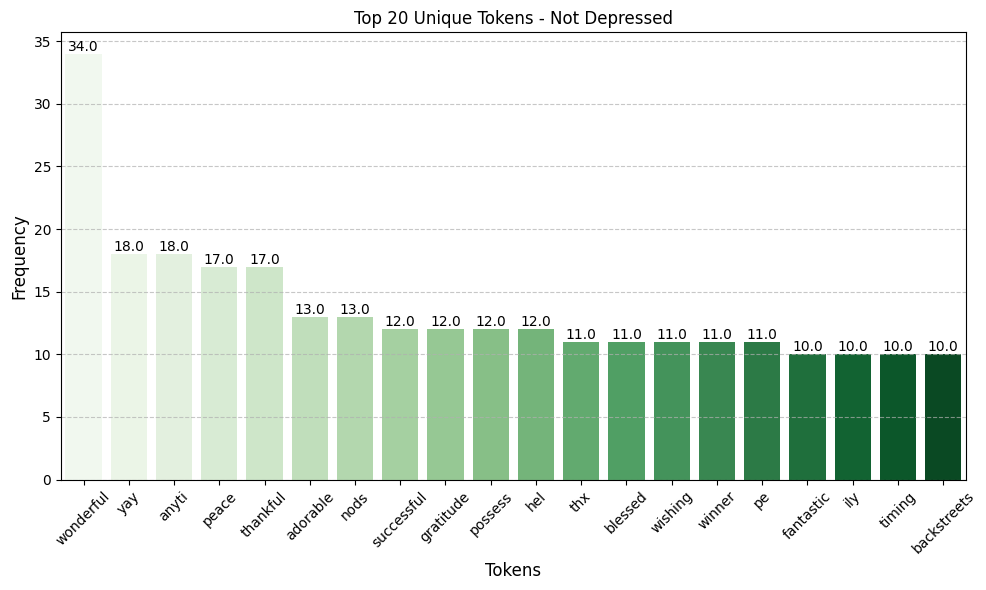

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_unique_top_tokens(df, 'Not Depressed', ['Moderately Depressed', 'Highly Depressed'], ax=ax, palette='Greens')
plt.title('Top 20 Unique Tokens - Not Depressed')
plt.tight_layout()
plt.show()


      followers                                                              \
          count      mean          std   min    25%    50%     75%      max   
label                                                                         
0       10000.0  921.7259   834.235466  11.0  235.0  640.0  1849.0   3088.0   
1       10000.0  879.2420  2553.988211   0.0  177.0  434.0   914.0  28614.0   

       friends             ... statuses            retweets             \
         count       mean  ...      75%        max    count       mean   
label                      ...                                           
0      10000.0   562.5893  ...  61856.0  1063601.0  10000.0  1818.8960   
1      10000.0  1002.2682  ...  13251.0    32925.0  10000.0  1056.9586   

                                                   
                std  min  25%  50%  75%       max  
label                                              
0      18794.064856  0.0  0.0  0.0  1.0  839540.0  
1      10184.509419  0.0 

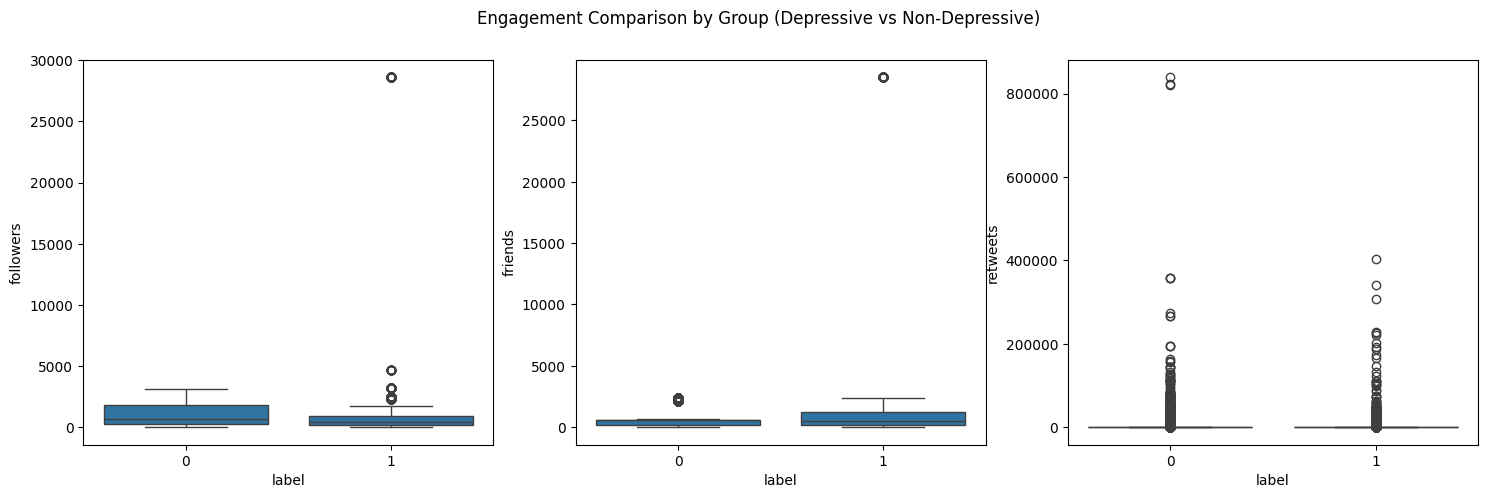

In [28]:
# Descriptive statistics by group
print(df.groupby('label')[['followers', 'friends', 'favourites', 'statuses', 'retweets']].describe())

# Boxplots comparing engagement metrics by group
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(data=df, x='label', y='followers', ax=axs[0])
sns.boxplot(data=df, x='label', y='friends', ax=axs[1])
sns.boxplot(data=df, x='label', y='retweets', ax=axs[2])
plt.suptitle('Engagement Comparison by Group (Depressive vs Non-Depressive)')
plt.show()


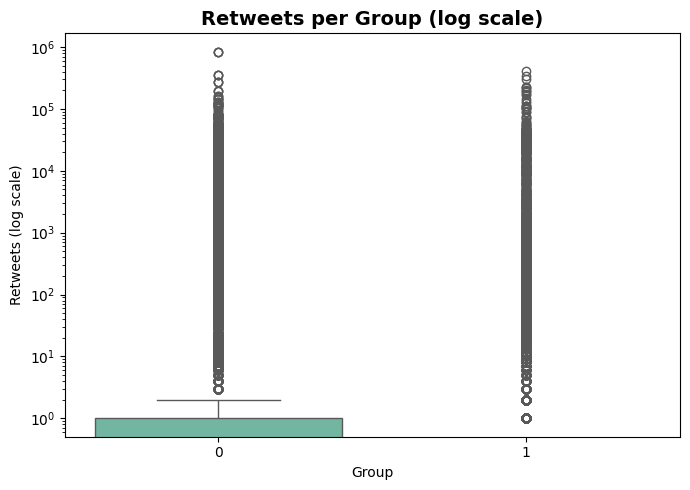

In [29]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='label', y='retweets', palette='Set2')
plt.yscale('log')
plt.title('Retweets per Group (log scale)', fontsize=14, fontweight='bold')
plt.xlabel('Group')
plt.ylabel('Retweets (log scale)')
plt.tight_layout()
plt.show()

In [30]:
#Feature engineering
from sklearn.preprocessing import LabelEncoder

# Label encoding for the target variable (depression_level)
le = LabelEncoder()

# Fit and transform the depression level labels to numeric values
y_encoded = le.fit_transform(df['depression_level'])

# Optionally, check the mapping of labels to integers
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Mapping:", label_mapping)


Label Encoding Mapping: {'Highly Depressed': 0, 'Moderately Depressed': 1, 'Not Depressed': 2}


In [31]:
# Vectorization of the cleaned text
vectorizer = TfidfVectorizer(
    max_features=5000,         # limits the vocabulary size
    ngram_range=(1, 2),        # unigrams and bigrams
    stop_words='english'       # remove English stopwords
)

# Apply vectorization on cleaned_review column
X = vectorizer.fit_transform(df['cleaned_review'].astype(str))

# Use the encoded depression_level as target
y = y_encoded  # Already label-encoded earlier

# Optional: check vocabulary size and sample features
print(f"TF-IDF Vocabulary Size: {len(vectorizer.get_feature_names_out())}")
print("Sample Features:", vectorizer.get_feature_names_out()[:10])


TF-IDF Vocabulary Size: 5000
Sample Features: ['aaronariff' 'aaroncarpenter' 'aartorias' 'abc' 'abc news' 'ability'
 'able' 'abroad' 'absolute' 'absolute madman']


In [32]:
# Training and testing separation
# Split with encoded target
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [33]:
#selected models

models = {
    "LogisticRegression": LogisticRegression(
        solver='liblinear',  # Good for small datasets or sparse input like TF-IDF
        max_iter=1000,
        random_state=42
    ),

    "SVM": LinearSVC(
        max_iter=1000,
        random_state=42
    ),

    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ),

    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='mlogloss',
        verbosity=0,
        random_state=42
    )
}

# Train and evaluate
results = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "y_pred": y_pred,
        "accuracy": acc,
        "classification_report": report
    }

   



Training model: LogisticRegression

Training model: SVM

Training model: RandomForest

Training model: XGBoost


In [34]:
#Convert your text to sequences
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
padded = pad_sequences(sequences, maxlen=100)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(padded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense

vocab_size = len(tokenizer.word_index) + 1

def build_rnn():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=100),
        SimpleRNN(64),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=100),
        LSTM(64),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [36]:
dl_results = {}

for name, builder in {'RNN': build_rnn, 'LSTM': build_lstm}.items():
    print(f"\nTraining DL model: {name}")
    model = builder()
    model.fit(X_train_dl, y_train_dl, epochs=5, batch_size=32, verbose=0)
    loss, acc = model.evaluate(X_test_dl, y_test_dl, verbose=0)
    dl_results[name] = {
        "accuracy": acc
    }



Training DL model: RNN

Training DL model: LSTM


In [37]:
# Merge all results
all_results = {**results, **dl_results}

# Print Accuracy Summary
print("\n# 5. Accuracy summary (sorted):\n")
for name, res in sorted(all_results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    print(f"{name}: {res['accuracy']:.4f}")



# 5. Accuracy summary (sorted):

LSTM: 0.8253
SVM: 0.7933
LogisticRegression: 0.7702
RNN: 0.7625
XGBoost: 0.7480
RandomForest: 0.5473


In [38]:

import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import create_optimizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["depression_level"]) 

# ==== 2. Encode the Text Inputs ====
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

def encode_examples(texts, labels, max_length=64):
    input_ids, attention_masks = [], []
    for t in texts:
        encoded = tokenizer.encode_plus(
            t,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])
    return (
        tf.convert_to_tensor(input_ids),
        tf.convert_to_tensor(attention_masks),
        tf.convert_to_tensor(labels)
    )

X_ids, X_mask, y_bert = encode_examples(df["cleaned_review"], y_encoded, max_length=64)

# Optionally split into training and test sets
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    X_ids.numpy(), X_mask.numpy(), y_bert.numpy(), test_size=0.2, random_state=42, stratify=y_bert.numpy()
)

# Convert to tensors
X_train_ids = tf.convert_to_tensor(X_train_ids)
X_train_mask = tf.convert_to_tensor(X_train_mask)
y_train = tf.convert_to_tensor(y_train)
X_test_ids = tf.convert_to_tensor(X_test_ids)
X_test_mask = tf.convert_to_tensor(X_test_mask)
y_test = tf.convert_to_tensor(y_test)

# ==== 3. Model Setup ====
NUM_LABELS = len(set(y_encoded))

model = TFAutoModelForSequenceClassification.from_pretrained(
    'prajjwal1/bert-tiny', num_labels=NUM_LABELS, from_pt=True
)


# Calculate total training steps
batch_size = 32
epochs = 6
steps_per_epoch = len(X_train_ids) // batch_size
num_train_steps = steps_per_epoch * epochs

# Create the optimizer using Hugging Face utility
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


history = model.fit(
    [X_train_ids, X_train_mask],
    y_train,
    validation_split=0.1,
    batch_size=16,
    epochs=4,  
    verbose=1
)


loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=1)
print("Test accuracy:", acc)



TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should p

Epoch 1/4


900/900 [==============================] - 257s 258ms/step - loss: 0.9466 - accuracy: 0.5474 - val_loss: 0.8025 - val_accuracy: 0.6631
Epoch 2/4
900/900 [==============================] - 227s 251ms/step - loss: 0.7328 - accuracy: 0.6996 - val_loss: 0.6641 - val_accuracy: 0.7331
Epoch 3/4
900/900 [==============================] - 231s 257ms/step - loss: 0.6473 - accuracy: 0.7441 - val_loss: 0.6306 - val_accuracy: 0.7462
Epoch 4/4
125/125 [==============================] - 16s 102ms/step - loss: 0.5956 - accuracy: 0.7763
Test accuracy: 0.7762500047683716


In [39]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
model_path = "../distilbert_depression_model" 

tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)

model = TFDistilBertForSequenceClassification.from_pretrained(model_path)

Some layers from the model checkpoint at ../distilbert_depression_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ../distilbert_depression_model and are newly initialized: ['dropout_27']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# Test it with example input
test_text = "I feel sad and hopeless all the time."
inputs = tokenizer(test_text, return_tensors="tf", truncation=True, padding=True)
outputs = model(**inputs)

predicted_class = tf.argmax(outputs.logits, axis=1).numpy()[0]
print(f"Predicted class: {predicted_class}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Predicted class: 0
